# A Pytorch DCGAN implementation 
## Deep Convolutional Generative Adversarial Network

This code is based on:

- [The original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf),

- [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py)

- Udacity deep learning nano degree.

The goal is render an image of E.Coli plate as:
<img src='few/few/3.jpg' width=30% />

In [ ]:
# Check if cuda (training on GPU is present)
import torch; print(torch.version.cuda)

In [1]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import ConcatDataset
from torchvision.transforms import InterpolationMode

import torchvision.transforms as T
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Hyperparams 

In [48]:
data_dir = 'few/'
TARGET_SIZE_X_Y = 64
batch_size = 64 # was 512
img_size = TARGET_SIZE_X_Y

# set number of epochs 
n_epochs = 200


# Define model hyperparams
d_conv_dim = 30
g_conv_dim = 90
z_size = 100

## Create dataloader

I found few images, so for now as experiment I will use an heavy augmented dataset 


In [23]:
def get_dataloader(batch_size, image_size, data_dir='few/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    for idx in range(20):
        preprocess = T.Compose([
            T.Resize(TARGET_SIZE_X_Y),
            T.CenterCrop(TARGET_SIZE_X_Y),
            #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            T.ToTensor(),
        ])

        preprocess_2 = T.Compose([
            T.RandomVerticalFlip(),
            T.Resize(TARGET_SIZE_X_Y),
            T.CenterCrop(TARGET_SIZE_X_Y),
            #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            T.ToTensor(),
        ])

        preprocess_5 = T.Compose([
            T.RandomHorizontalFlip(p=1),
            T.RandomVerticalFlip(),
            T.Resize(TARGET_SIZE_X_Y),
            T.CenterCrop(TARGET_SIZE_X_Y),
            #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            T.ToTensor(),
        ])

        preprocess_3 = T.Compose([
            T.RandomVerticalFlip(p=1),
            T.RandomRotation(degrees=40),
            T.Resize(TARGET_SIZE_X_Y),
            T.CenterCrop(TARGET_SIZE_X_Y),
            #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            T.ToTensor(),
        ])

        preprocess_4 = T.Compose([
            T.RandomRotation(degrees=50),
            T.RandomPerspective(distortion_scale=0.1, p=0.5,
                                interpolation=3, fill=0),
            T.Resize(TARGET_SIZE_X_Y),
            T.CenterCrop(TARGET_SIZE_X_Y),
            #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            T.ToTensor(),
        ])

        dataset = datasets.ImageFolder(data_dir,
                                       transform=preprocess)
        dataset2 = datasets.ImageFolder(data_dir,
                                        transform=preprocess_2)
        dataset3 = datasets.ImageFolder(data_dir,
                                        transform=preprocess_3)
        dataset4 = datasets.ImageFolder(data_dir,
                                        transform=preprocess_4)
        dataset5 = datasets.ImageFolder(data_dir,
                                    transform=preprocess_5)
        # Concat Augmented datasets
        if(idx == 0):
            concat_dataset = ConcatDataset(
                [dataset2, dataset3, dataset4, dataset, dataset5])
        else:
             concat_dataset = ConcatDataset(
                [concat_dataset,dataset2, dataset3, dataset4, dataset, dataset5])
    # Moltiply datasets
    # concat_dataset = ConcatDataset([concat_dataset,concat_dataset,concat_dataset,concat_dataset,concat_dataset,concat_dataset])
    print(f"the dataset is composed by {len(concat_dataset)} elements")
    data_loader = torch.utils.data.DataLoader(dataset=concat_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

    return data_loader

In [25]:


# Call your function and get a dataloader
train_loader = get_dataloader(batch_size, (TARGET_SIZE_X_Y, TARGET_SIZE_X_Y))


the dataset is composed by 400 elements


Let see some images from dataset

C:\Users\marco\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


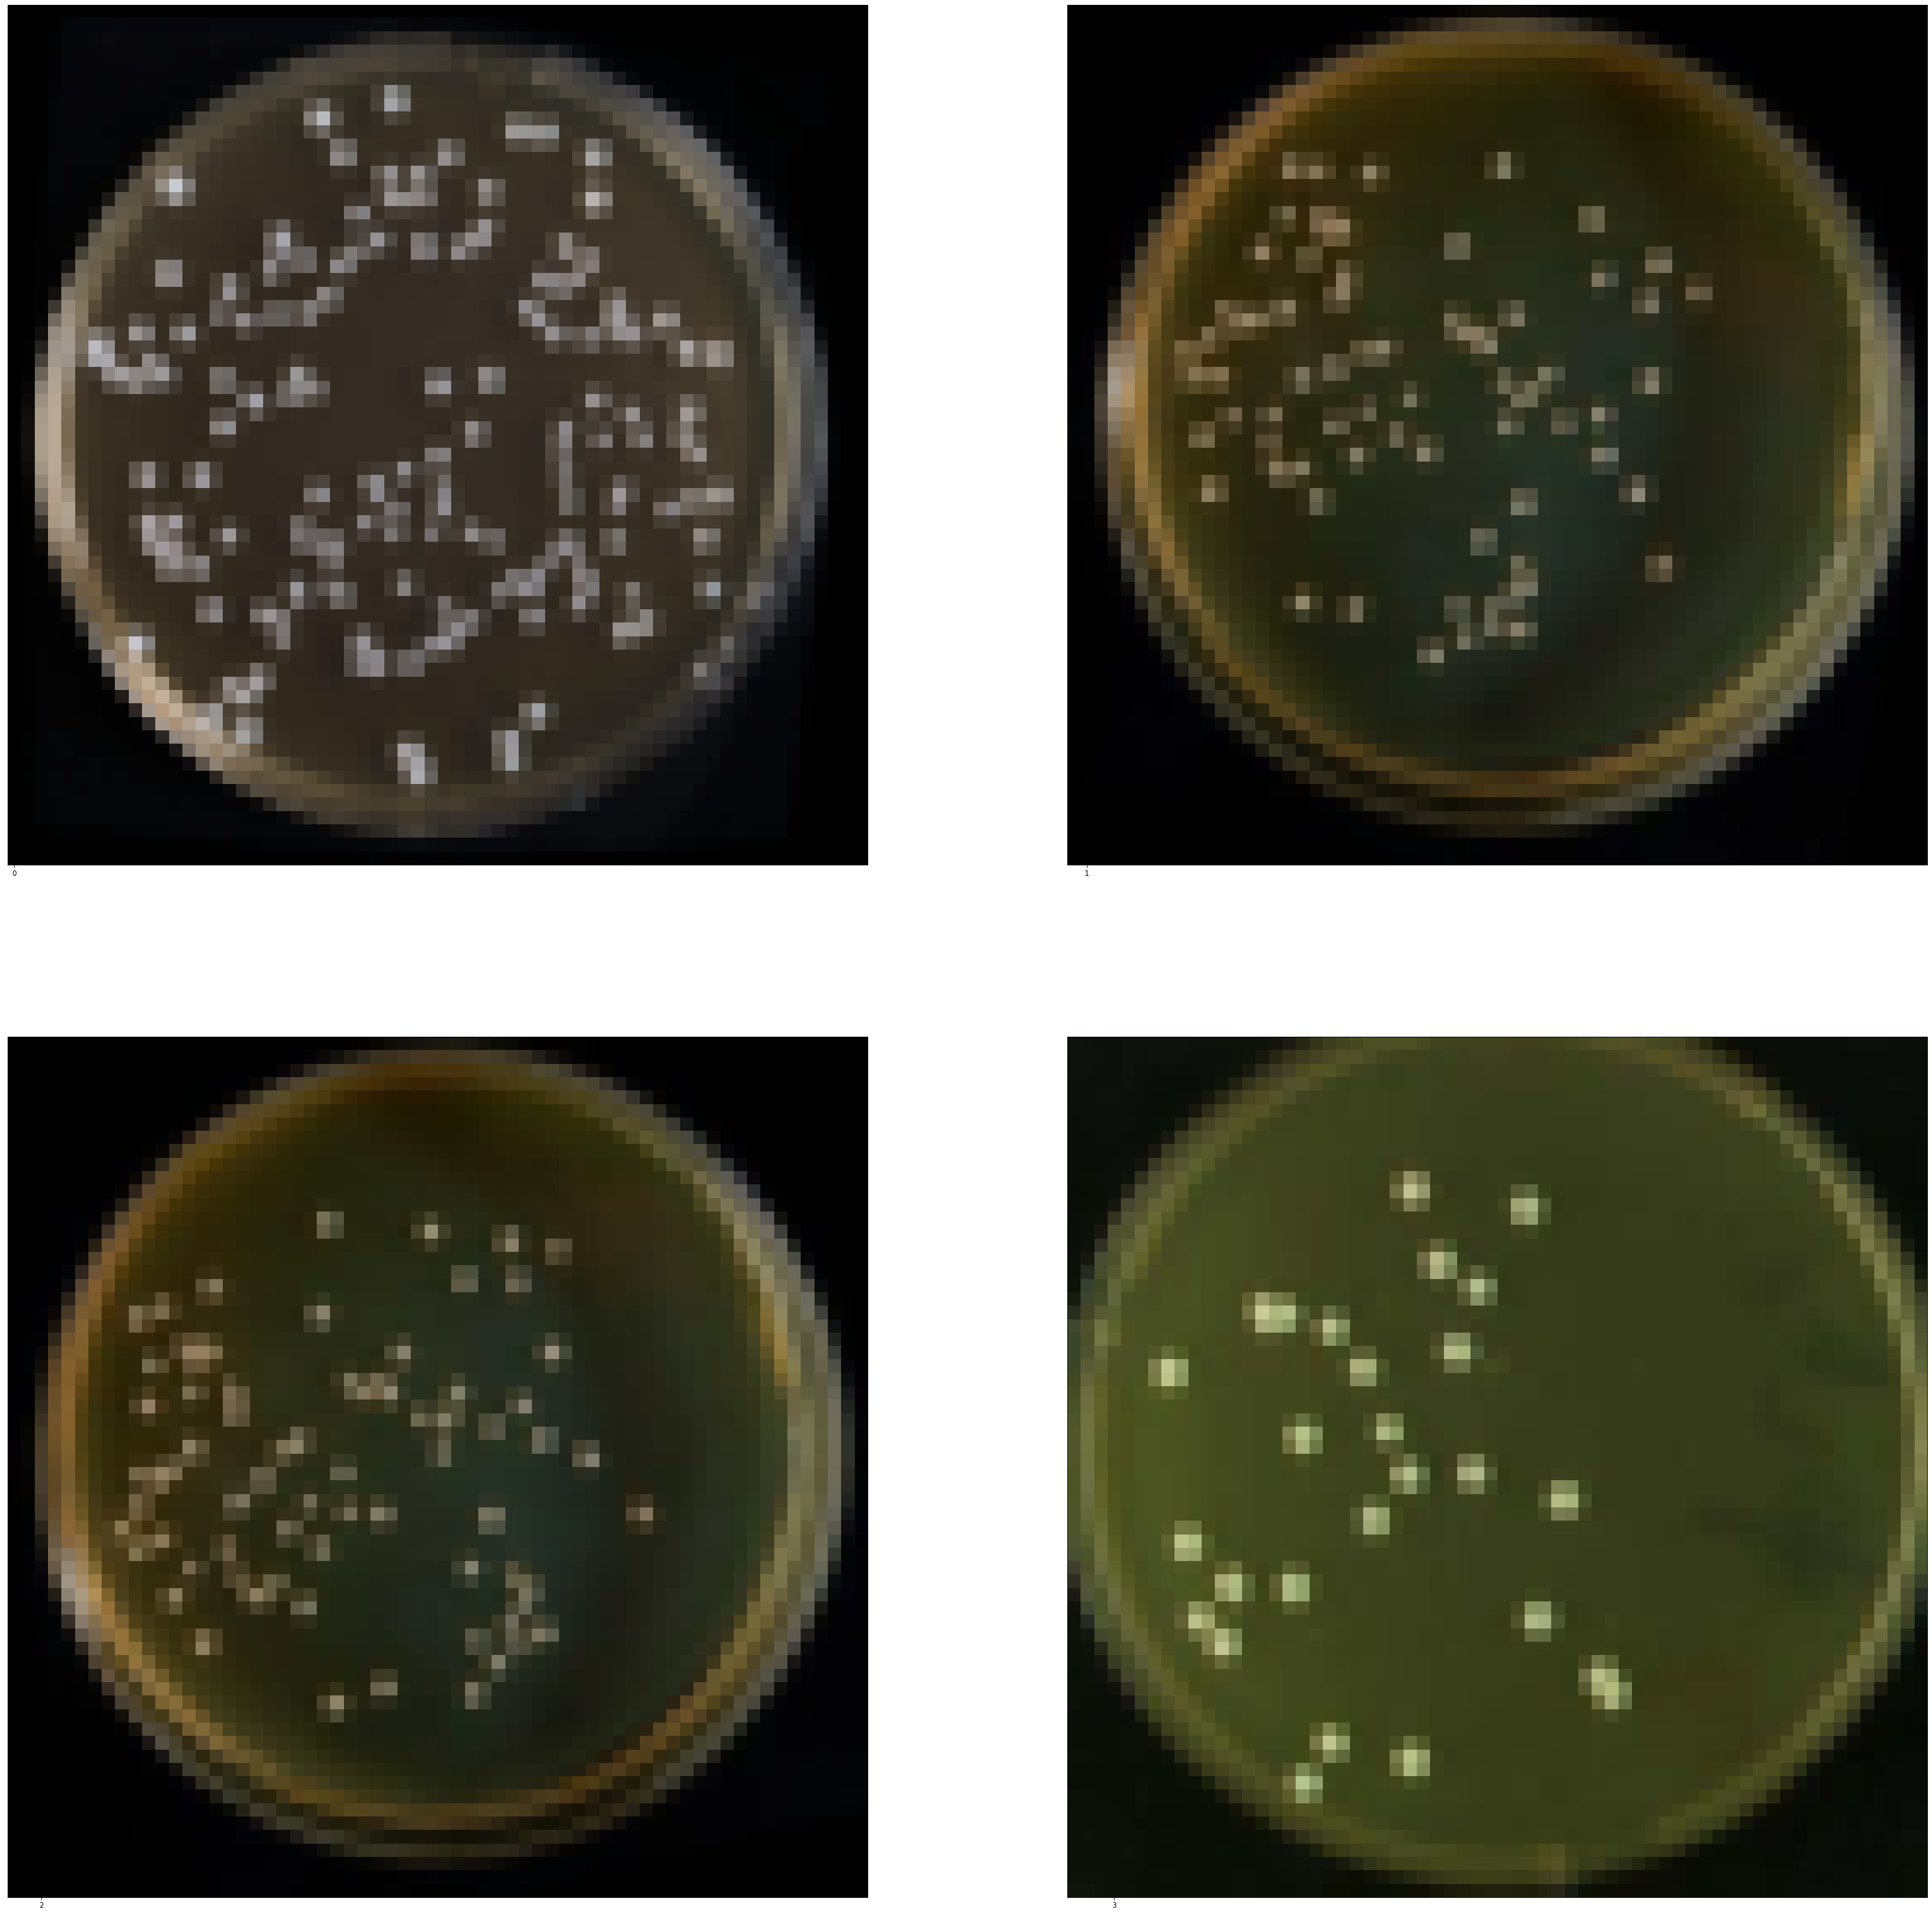

In [26]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50, 50))
plot_size=4
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[idx %20], yticks=[])
    img_idx = idx % 25
    imshow(images[img_idx])

Rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [27]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [28]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.6549)


---
## Discriminator

A GAN is comprised of two adversarial networks, a discriminator and a generator.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [31]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # [input] 32x32  now 64x64
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 [out]
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        #print(f"discriminator {x.shape}")
        
        output = F.leaky_relu(self.conv1(x), 0.18)
        output = F.leaky_relu(self.conv2(output), 0.18)
        output = F.leaky_relu(self.conv3(output), 0.18)
        
        # flatten
        output = output.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        output = self.fc(output)        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_discriminator(Discriminator,64)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `64x64x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [32]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    #print(f"-- in_channels{in_channels}  out_channels{out_channels} kernel_size:{kernel_size} stride{stride} padding{padding}")
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [33]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, conv_dim, 4, batch_norm=False)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        #print(f" conv1 {out.shape}")
        out = F.relu(self.t_conv2(out))
        #print(f" conv2 {out.shape}")
        out = F.relu(self.t_conv3(out))
        #print(f" conv3 {out.shape}")
        
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        #print(f" conv4 {out.shape}")
        out = self.t_conv5(out)
        #print(f" conv5 {out.shape}")
        out = F.tanh(out)
        
        return out

## Initialize the weights of your networks

From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

In [58]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant_(m.bias.data, 0.0)
    

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [36]:
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(60, 120, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1920, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2880, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(720, 360, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(360, 180, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

### Training on GPU if possible

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

In [38]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    
    if train_on_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [39]:
import torch.optim as optim

lr=0.001
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

In [40]:
def train(D, G, n_epochs, print_every=10):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=6
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = int(real_images.size(0))
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # Generate fake images

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward(retain_graph=True)
            d_optimizer.step()            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward(retain_graph=True)
            g_optimizer.step()
                                    
            g_optimizer.zero_grad()
            
            
                                    
            
            

            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [49]:
# call training function
losses = train(D, G, n_epochs=n_epochs)

C:\Users\marco\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  200] | d_loss: 1.5633 | g_loss: 1.1163
Epoch [    2/  200] | d_loss: 0.9515 | g_loss: 2.2894
Epoch [    3/  200] | d_loss: 0.9685 | g_loss: 2.0996
Epoch [    4/  200] | d_loss: 0.9927 | g_loss: 2.1895
Epoch [    5/  200] | d_loss: 0.9480 | g_loss: 1.5816
Epoch [    6/  200] | d_loss: 1.2984 | g_loss: 2.2994
Epoch [    7/  200] | d_loss: 1.3357 | g_loss: 2.4845
Epoch [    8/  200] | d_loss: 1.2668 | g_loss: 2.1899
Epoch [    9/  200] | d_loss: 1.2225 | g_loss: 1.9139
Epoch [   10/  200] | d_loss: 1.2127 | g_loss: 1.6440
Epoch [   11/  200] | d_loss: 1.2993 | g_loss: 2.1741
Epoch [   12/  200] | d_loss: 1.3115 | g_loss: 1.1074
Epoch [   13/  200] | d_loss: 1.2943 | g_loss: 1.2441
Epoch [   14/  200] | d_loss: 1.2088 | g_loss: 1.9432
Epoch [   15/  200] | d_loss: 1.1624 | g_loss: 1.7915
Epoch [   16/  200] | d_loss: 1.1642 | g_loss: 1.4701
Epoch [   17/  200] | d_loss: 1.1151 | g_loss: 1.8243
Epoch [   18/  200] | d_loss: 1.3671 | g_loss: 2.0068
Epoch [   19/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.4108 | g_loss: 2.5528
Epoch [  154/  200] | d_loss: 0.3603 | g_loss: 3.6245
Epoch [  155/  200] | d_loss: 1.0746 | g_loss: 5.6552
Epoch [  156/  200] | d_loss: 1.1538 | g_loss: 5.2747
Epoch [  157/  200] | d_loss: 0.7332 | g_loss: 2.3805
Epoch [  158/  200] | d_loss: 0.4195 | g_loss: 3.6359
Epoch [  159/  200] | d_loss: 0.6214 | g_loss: 3.8809
Epoch [  160/  200] | d_loss: 0.6725 | g_loss: 3.7579
Epoch [  161/  200] | d_loss: 0.7314 | g_loss: 4.9250
Epoch [  162/  200] | d_loss: 0.3917 | g_loss: 2.4342
Epoch [  163/  200] | d_loss: 0.6420 | g_loss: 5.8126
Epoch [  164/  200] | d_loss: 0.7073 | g_loss: 1.4382
Epoch [  165/  200] | d_loss: 1.3005 | g_loss: 5.2144
Epoch [  166/  200] | d_loss: 0.3722 | g_loss: 2.7265
Epoch [  167/  200] | d_loss: 0.2902 | g_loss: 2.9251
Epoch [  168/  200] | d_loss: 0.2990 | g_loss: 3.6609
Epoch [  169/  200] | d_loss: 0.5075 | g_loss: 2.3754
Epoch [  170/  200] | d_loss: 0.2394 | g_loss: 3.3687
Epoch [  171/  200] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

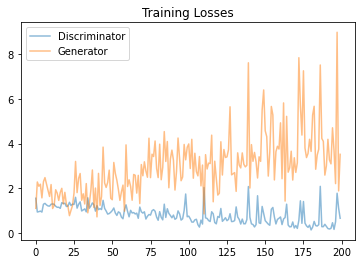

In [50]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")


plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [51]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,16), nrows=1, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        #print(img.shape)
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))

In [52]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

C:\Users\marco\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


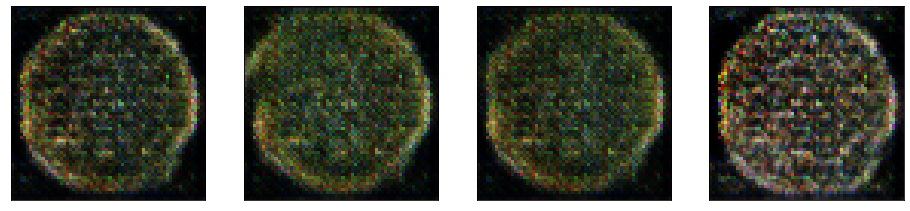

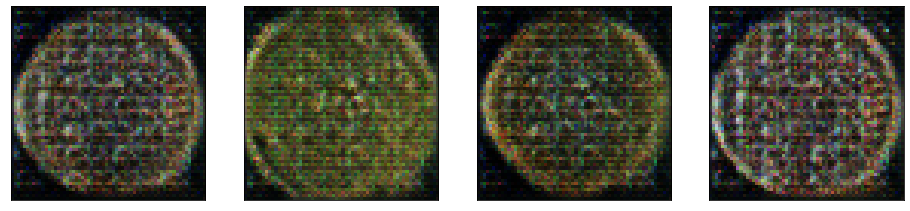

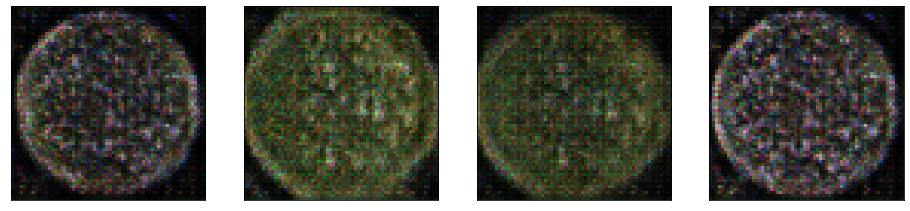

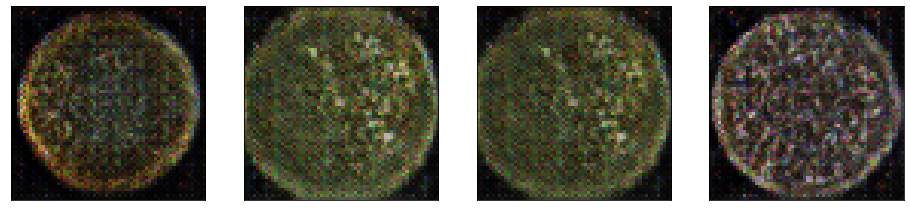

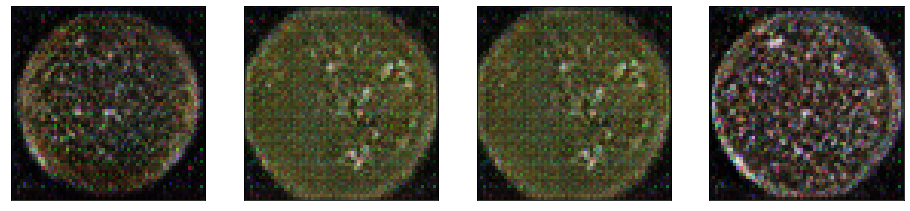

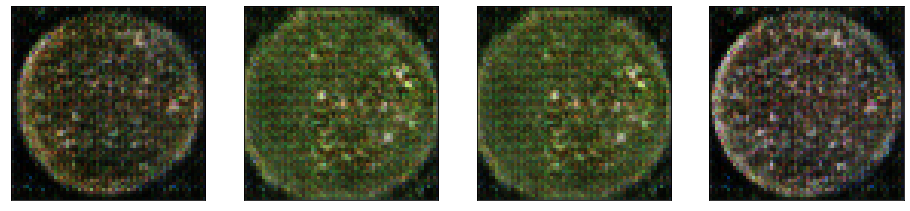

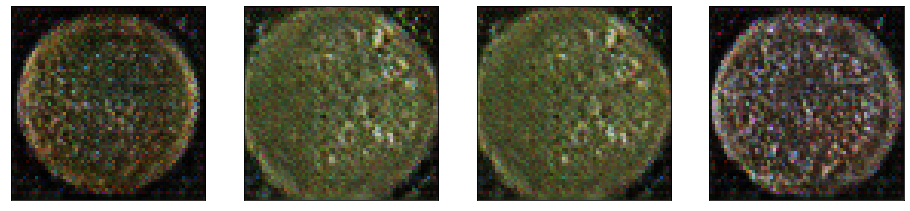

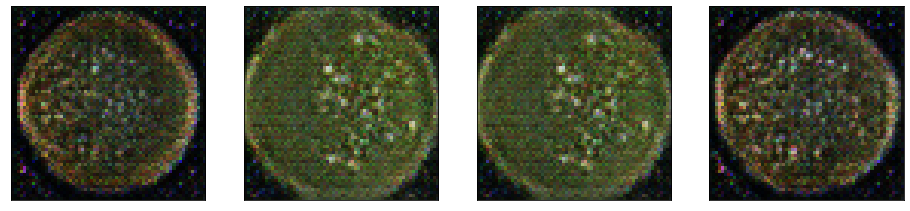

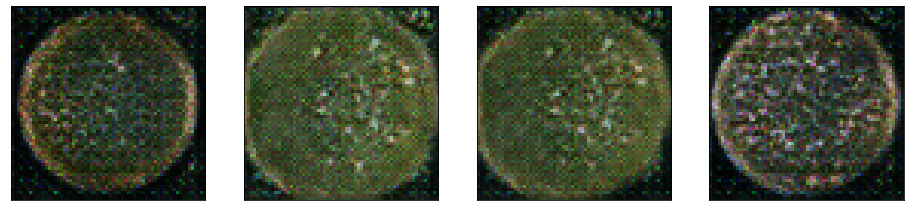

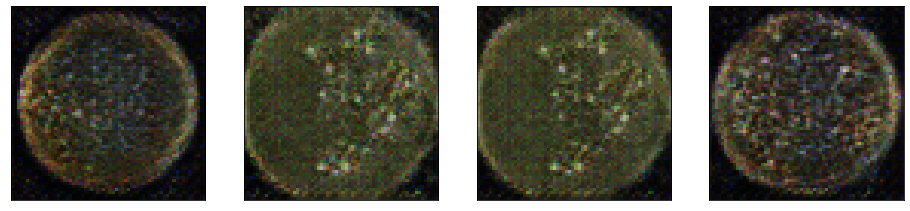

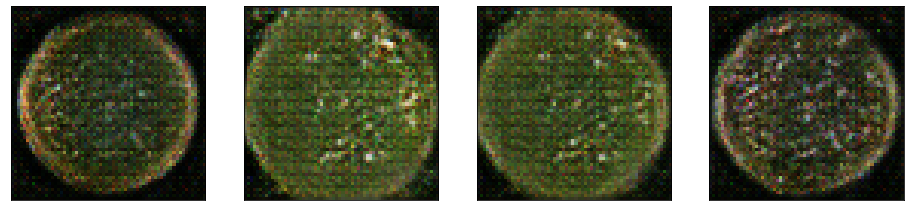

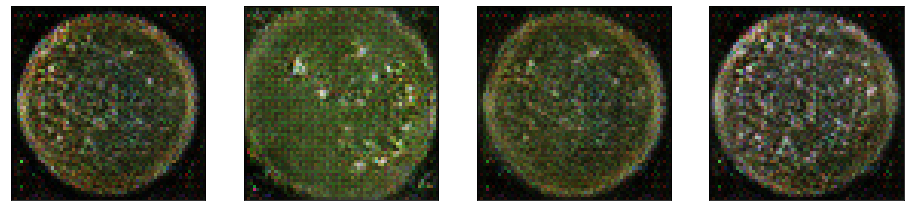

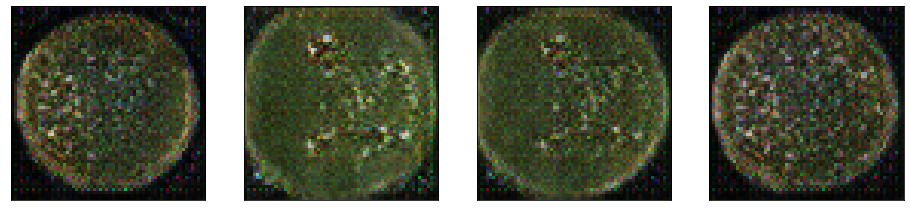

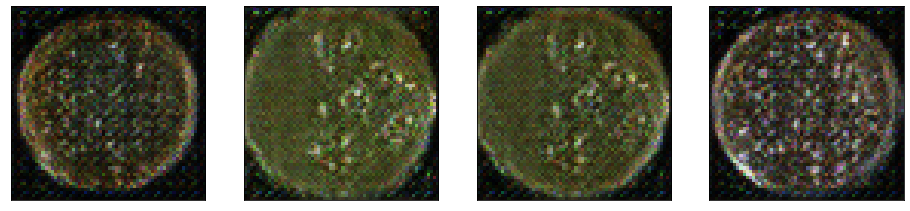

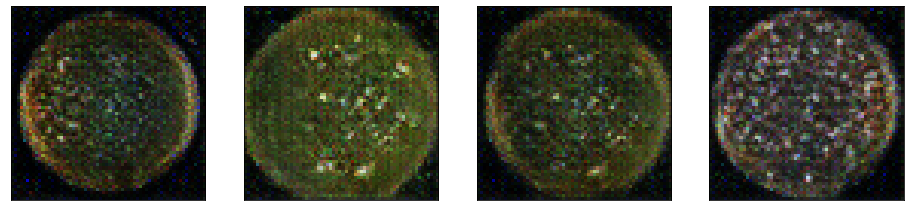

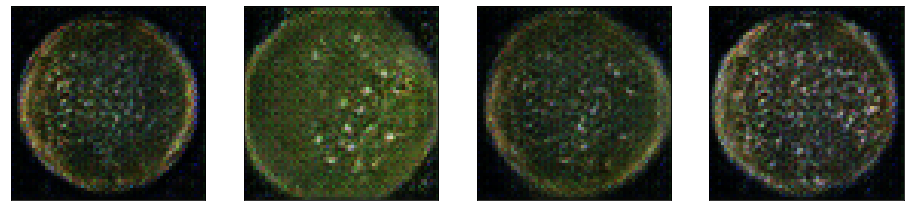

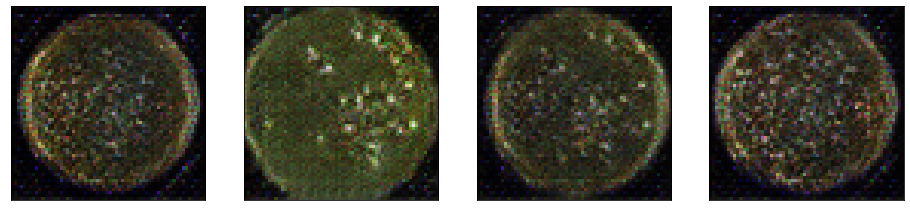

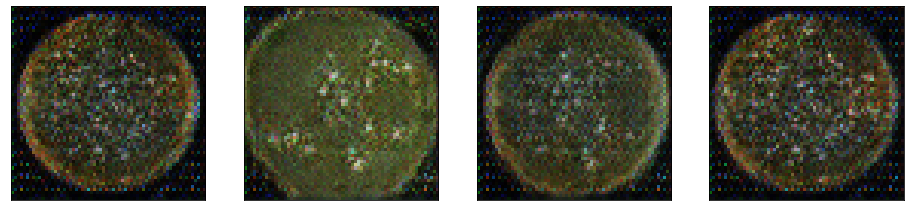

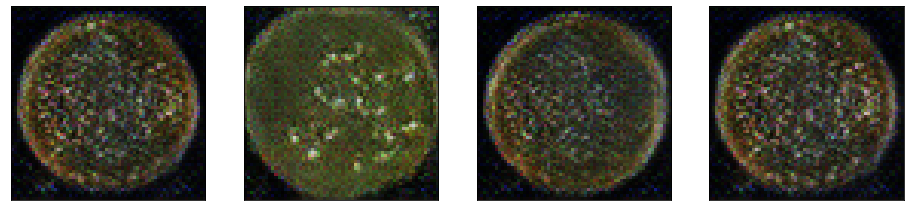

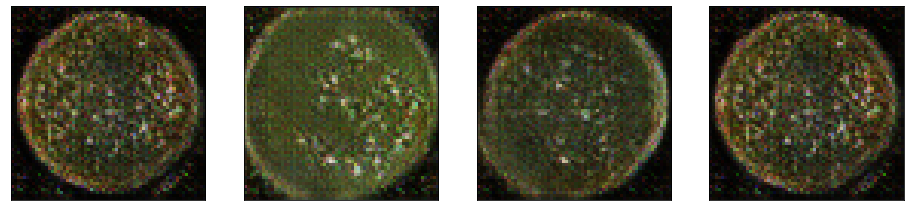

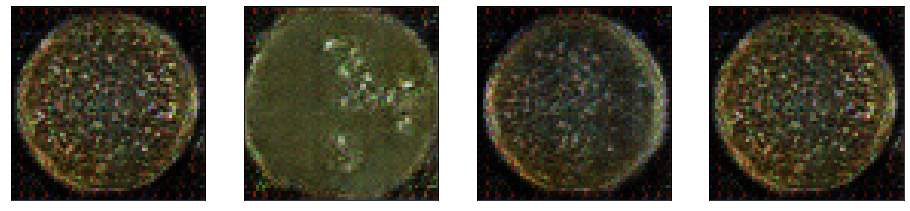

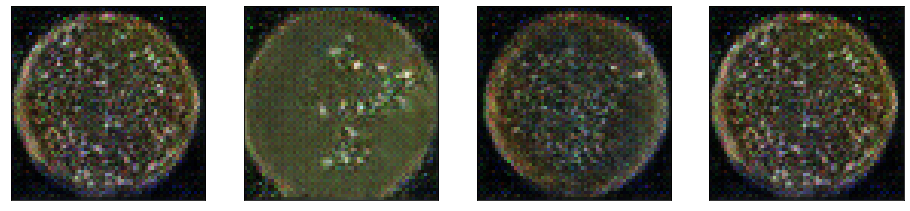

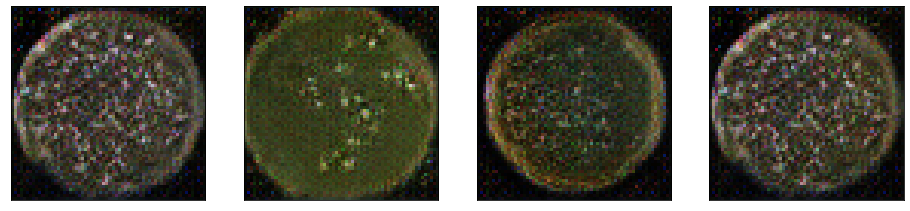

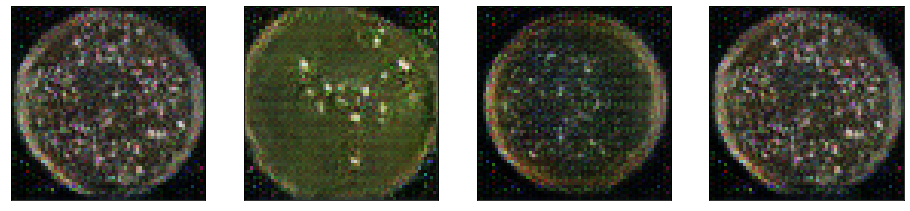

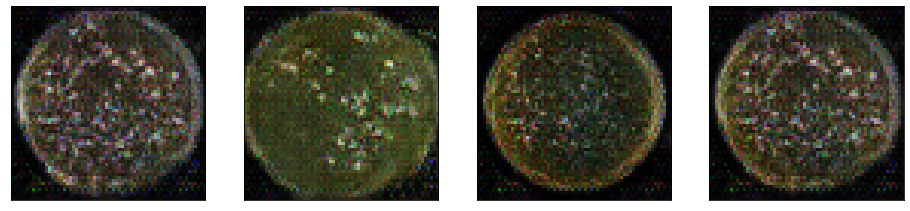

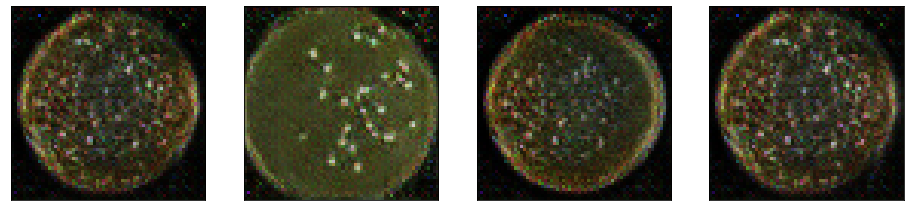

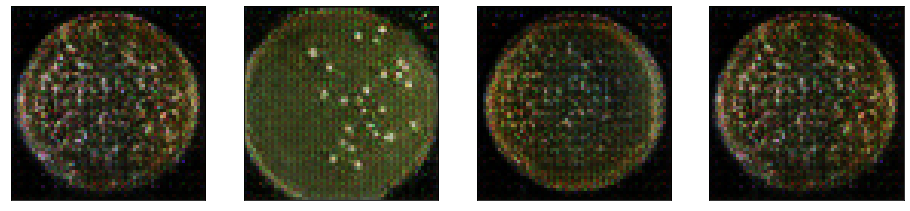

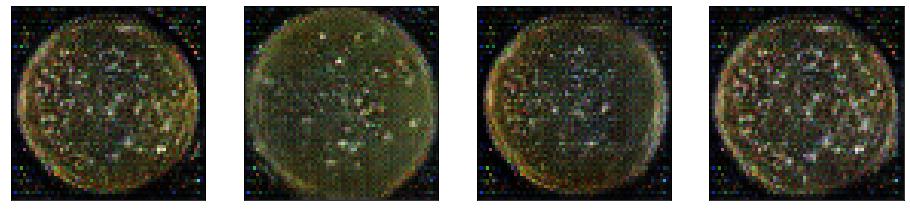

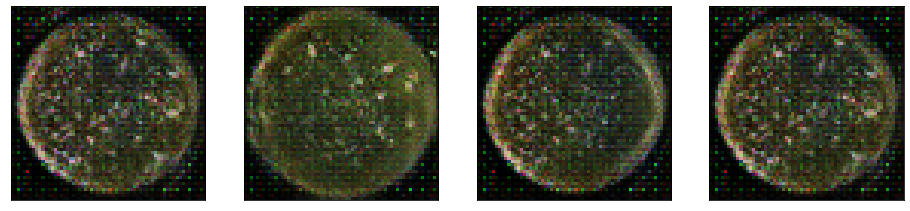

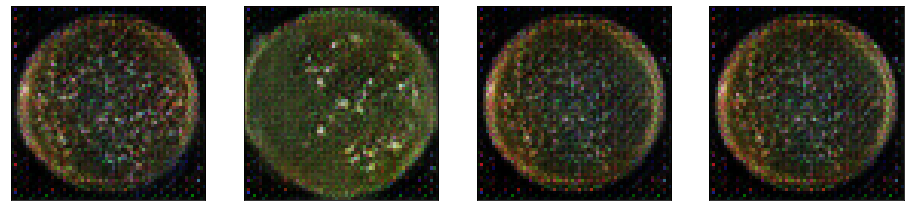

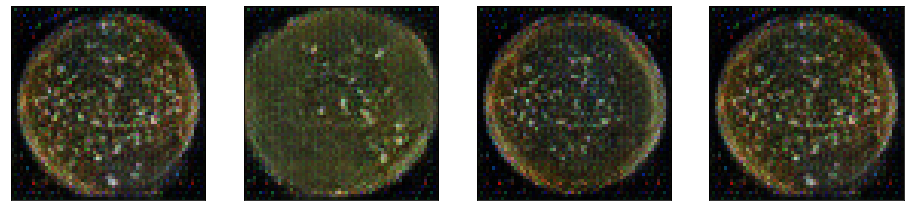

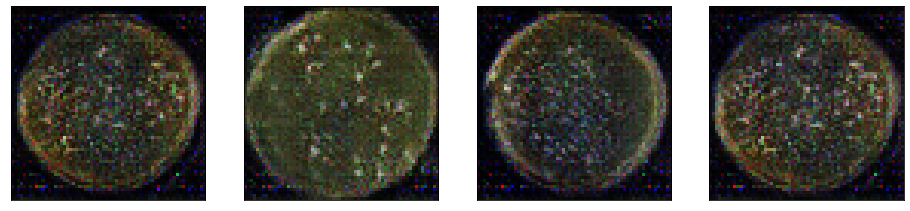

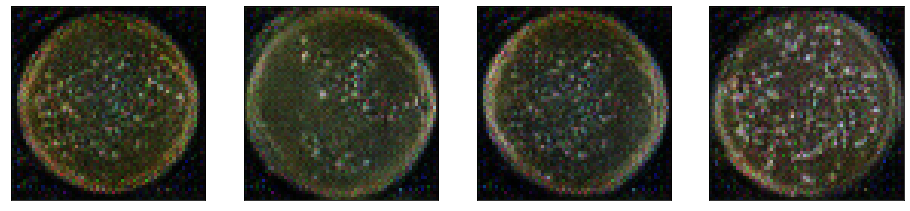

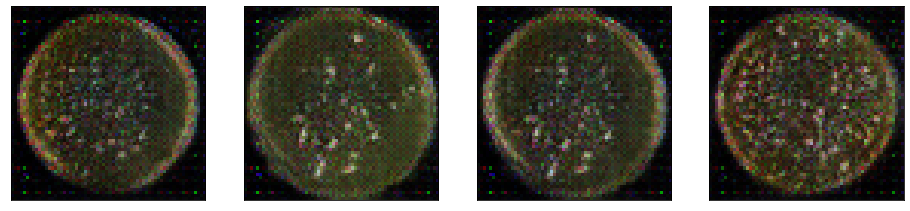

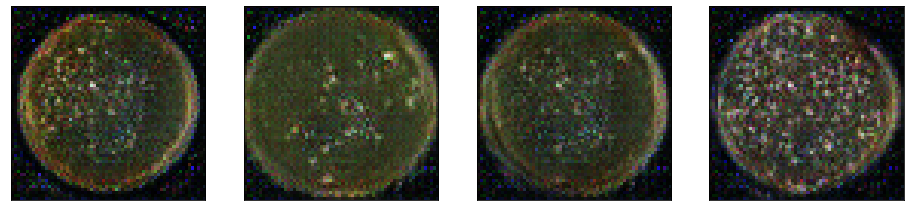

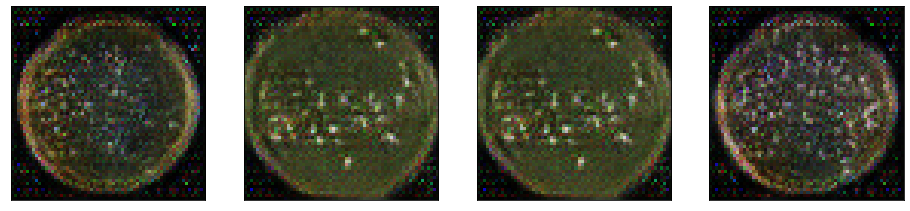

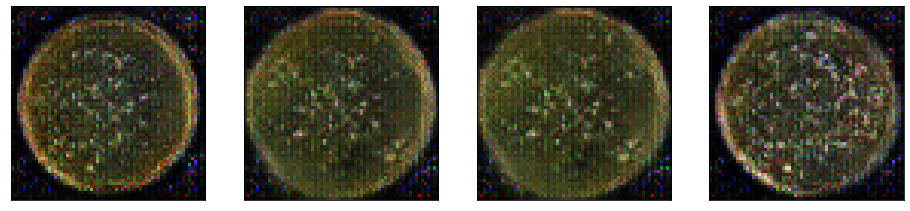

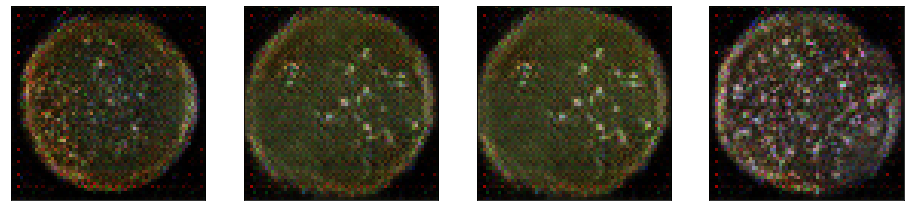

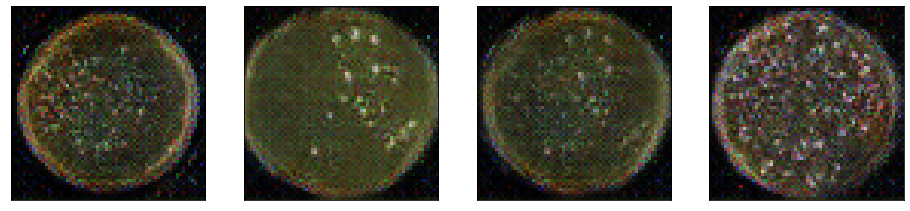

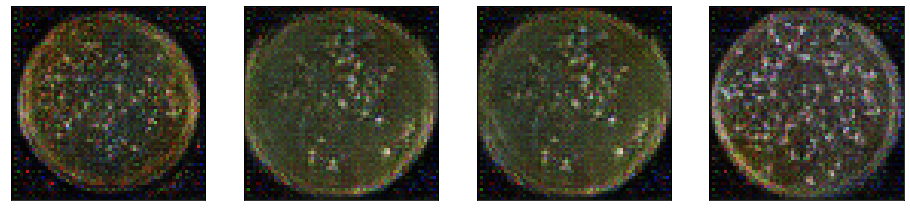

In [53]:

for i in range(1,n_epochs,5):
    _ = view_samples(i, samples)

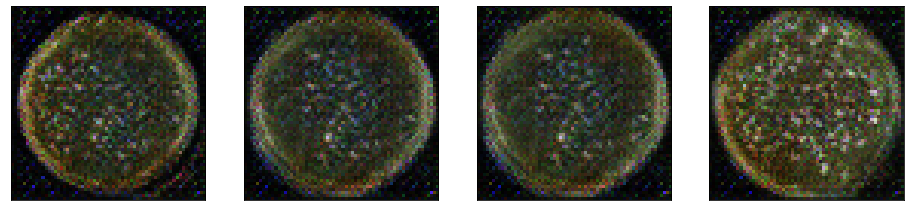

In [57]:

view_samples(n_epochs-1, samples)